# END-TO-END REGRESSION: SONG YEAR PREDICTION

**Project Overview:**
This notebook implements a complete machine learning pipeline to predict the release year of songs based on audio features. It includes professional data handling, outlier detection, advanced modeling (Random Forest & XGBoost), and comprehensive evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import warnings
import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("\n✓ All libraries imported successfully!")


✓ All libraries imported successfully!


## 1. Data Loading & Inspection

In [3]:
print(f"\n{'─'*50}")
print("PHASE 1: DATA LOADING")
print(f"{'─'*50}")

output_file = 'midterm-regresi-dataset.csv'
file_id = '1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9'
url = f'https://drive.google.com/uc?id={file_id}'

if not os.path.exists(output_file):
    print(f"• Downloading dataset from Google Drive...")
    gdown.download(url, output_file, quiet=False)
    print("✓ Download complete.")
else:
    print("✓ Dataset already exists locally.")

# Load Data
print("• Reading CSV file...")
df = pd.read_csv(output_file, header=None)

# Rename columns
num_features = df.shape[1] - 1
cols = ['year'] + [f'feature_{i}' for i in range(1, num_features + 1)]
df.columns = cols

print(f"\n──────────────────────────────────────────────────")
print("OUTPUT 1.1: DATASET STATISTICS")
print(f"──────────────────────────────────────────────────")
print(f"• Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"• Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n• First 5 Rows Preview:")
print(df.head().iloc[:, :6].to_string()) # Show only first 6 cols for brevity
print("  ...")


──────────────────────────────────────────────────
PHASE 1: DATA LOADING
──────────────────────────────────────────────────
• Downloading dataset from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=a0c3eed4-e28d-4d2e-954c-bff866baf0d1
To: /content/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:05<00:00, 85.9MB/s]


✓ Download complete.
• Reading CSV file...

──────────────────────────────────────────────────
OUTPUT 1.1: DATASET STATISTICS
──────────────────────────────────────────────────
• Shape: 515,345 rows × 91 columns
• Memory Usage: 357.79 MB

• First 5 Rows Preview:
   year  feature_1  feature_2  feature_3  feature_4  feature_5
0  2001   49.94357   21.47114   73.07750    8.74861  -17.40628
1  2001   48.73215   18.42930   70.32679   12.94636  -10.32437
2  2001   50.95714   31.85602   55.81851   13.41693   -6.57898
3  2001   48.24750   -1.89837   36.29772    2.58776    0.97170
4  2001   50.97020   42.20998   67.09964    8.46791  -15.85279
  ...


## 2. Exploratory Data Analysis (EDA)


──────────────────────────────────────────────────
PHASE 2: TARGET VARIABLE ANALYSIS (Year)
──────────────────────────────────────────────────
count    515345.000000
mean       1998.397082
std          10.931046
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2011.000000
Name: year, dtype: float64

• Year Range: 1922 - 2011
• Most Common Year: 2007


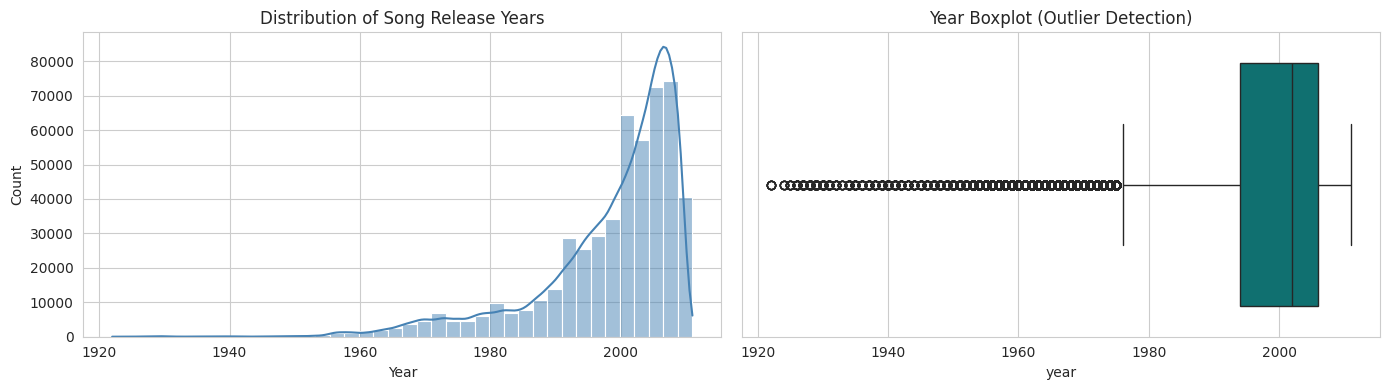

In [4]:
print(f"\n{'─'*50}")
print("PHASE 2: TARGET VARIABLE ANALYSIS (Year)")
print(f"{'─'*50}")

target_stats = df['year'].describe()
print(target_stats)
print(f"\n• Year Range: {int(df['year'].min())} - {int(df['year'].max())}")
print(f"• Most Common Year: {int(df['year'].mode()[0])}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Hist Plot
sns.histplot(df['year'], bins=40, kde=True, color='steelblue', ax=axes[0])
axes[0].set_title('Distribution of Song Release Years', fontsize=12)
axes[0].set_xlabel('Year')

# Box Plot
sns.boxplot(x=df['year'], color='teal', ax=axes[1])
axes[1].set_title('Year Boxplot (Outlier Detection)', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Data Cleaning & Feature Selection

In [5]:
print(f"\n{'─'*50}")
print("PHASE 3: CLEANING & SELECTION")
print(f"{'─'*50}")

# 3.1 Duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows.")
else:
    print("✓ No duplicates found.")

# 3.2 Feature Selection (Correlation)
print("\n• Calculating correlations...")
correlations = df.corr()['year'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > 0.05].index.tolist()
if 'year' in selected_features: selected_features.remove('year')

print(f"• Original Features: 90")
print(f"• Selected Features: {len(selected_features)} (Correlation > 0.05)")
print(f"✓ Top 5 Features: {selected_features[:5]}")

X = df[selected_features]
y = df['year']


──────────────────────────────────────────────────
PHASE 3: CLEANING & SELECTION
──────────────────────────────────────────────────
✓ Removed 214 duplicate rows.

• Calculating correlations...
• Original Features: 90
• Selected Features: 38 (Correlation > 0.05)
✓ Top 5 Features: ['feature_1', 'feature_6', 'feature_3', 'feature_63', 'feature_40']


## 4. Preprocessing & Outlier Handling

In [6]:
print(f"\n{'─'*50}")
print("PHASE 4: PREPROCESSING")
print(f"{'─'*50}")

# 4.1 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"• Training Set: {X_train.shape[0]:,} samples")
print(f"• Test Set: {X_test.shape[0]:,} samples")

# 4.2 Outlier Handling (Clipping 1st and 99th percentile)
# Providing robustness against extreme audio artifacts
print("• Handling outliers (Clipping method)...")
for col in X_train.columns:
    lower = X_train[col].quantile(0.01)
    upper = X_train[col].quantile(0.99)
    X_train[col] = X_train[col].clip(lower, upper)
    X_test[col] = X_test[col].clip(lower, upper)

# 4.3 Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Data scaled (StandardScaler) and outliers clipped.")


──────────────────────────────────────────────────
PHASE 4: PREPROCESSING
──────────────────────────────────────────────────
• Training Set: 412,104 samples
• Test Set: 103,027 samples
• Handling outliers (Clipping method)...
✓ Data scaled (StandardScaler) and outliers clipped.


## 5. Model Training (Advanced Ensembles)

In [7]:
print(f"\n{'─'*50}")
print("PHASE 5: MODEL TRAINING")
print(f"{'─'*50}")

# --- Model 1: Random Forest ---
print("1. Training Random Forest (Baseline)...")
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("   ✓ Random Forest training complete.")

# --- Model 2: XGBoost (Tuned) ---
print("\n2. Training XGBoost with Hyperparameter Tuning...")
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

random_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print(f"   ✓ XGBoost training complete.")
print(f"   • Best Params: {random_search.best_params_}")


──────────────────────────────────────────────────
PHASE 5: MODEL TRAINING
──────────────────────────────────────────────────
1. Training Random Forest (Baseline)...
   ✓ Random Forest training complete.

2. Training XGBoost with Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
   ✓ XGBoost training complete.
   • Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

X_train_scaled = X_train_scaled.astype("float32")
X_val_scaled   = X_val_scaled.astype("float32")


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

input_dim = X_train_scaled.shape[1]

model_reg = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="linear")   # output 1 nilai kontinu (tahun)
])

model_reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae", "mse"]
)

model_reg.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True
)

history = model_reg.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=1024,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 3130418.7500 - mae: 1704.3521 - mse: 3130418.7500 - val_loss: 438768.8438 - val_mae: 534.2857 - val_mse: 438768.8438
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 409630.1562 - mae: 512.9135 - mse: 409630.1562 - val_loss: 198616.7031 - val_mae: 338.1257 - val_mse: 198616.7031
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 239604.9375 - mae: 380.7072 - mse: 239604.9375 - val_loss: 113873.3672 - val_mae: 249.3420 - val_mse: 113873.3672
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 165719.2344 - mae: 313.6358 - mse: 165719.2344 - val_loss: 57673.0586 - val_mae: 171.9081 - val_mse: 57673.0586
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 113482.6797 - mae: 259.8016 - mse: 113482.6797 - val_loss: 24639.0117 - val_mae: 108.4866 - val_mse: 24639.0117
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 83453.6875 - mae: 225.6877 - mse: 83453.6875 - val_loss: 10465.74

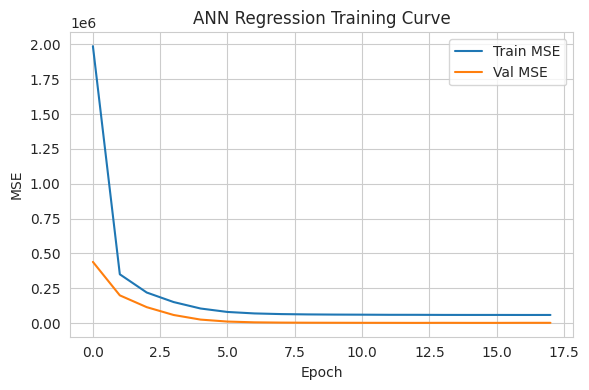

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("ANN Regression Training Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_val_pred_dl = model_reg.predict(X_val_scaled).ravel()

mse_dl  = mean_squared_error(y_val, y_val_pred_dl)
rmse_dl = np.sqrt(mse_dl)
mae_dl  = mean_absolute_error(y_val, y_val_pred_dl)
r2_dl   = r2_score(y_val, y_val_pred_dl)

print("=== Deep Learning Regression Performance ===")
print(f"MSE  : {mse_dl:.4f}")
print(f"RMSE : {rmse_dl:.4f}")
print(f"MAE  : {mae_dl:.4f}")
print(f"R^2  : {r2_dl:.4f}")


3220/3220 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
=== Deep Learning Regression Performance ===
MSE  : 1022.5723
RMSE : 31.9777
MAE  : 28.5383
R^2  : -7.6891


In [17]:
rf_metrics = results_df[results_df['Model'] == 'Random Forest'].iloc[0]
rmse_rf = rf_metrics['RMSE']
r2_rf = rf_metrics['R2']

xgb_metrics = results_df[results_df['Model'] == 'XGBoost (Tuned)'].iloc[0]
rmse_xgb = xgb_metrics['RMSE']
r2_xgb = xgb_metrics['R2']

print("\n=== Comparison (lower MSE/RMSE/MAE is better, higher R^2 is better) ===")
print(f"Random Forest      - RMSE: {rmse_rf:.4f}, R^2: {r2_rf:.4f}")
print(f"XGBoost (Tuned)    - RMSE: {rmse_xgb:.4f}, R^2: {r2_xgb:.4f}")
print(f"Deep Learning (ANN)- RMSE: {rmse_dl:.4f}, R^2: {r2_dl:.4f}")


=== Comparison (lower MSE/RMSE/MAE is better, higher R^2 is better) ===
Random Forest      - RMSE: 9.4846, R^2: 0.2356
XGBoost (Tuned)    - RMSE: 9.2181, R^2: 0.2780
Deep Learning (ANN)- RMSE: 31.9777, R^2: -7.6891


## 6. Evaluation & Visualization


──────────────────────────────────────────────────
PHASE 6: EVALUATION & RESULTS
──────────────────────────────────────────────────

──────────────────────────────────────────────────
EXECUTIVE SUMMARY: MODEL PERFORMANCE
──────────────────────────────────────────────────
          Model     RMSE      MAE       R2
XGBoost (Tuned) 9.218066 6.588012 0.277964
  Random Forest 9.484563 6.776283 0.235612

★ BEST MODEL: XGBoost (Tuned)
  • RMSE: 9.2181
  • R²  : 0.2780


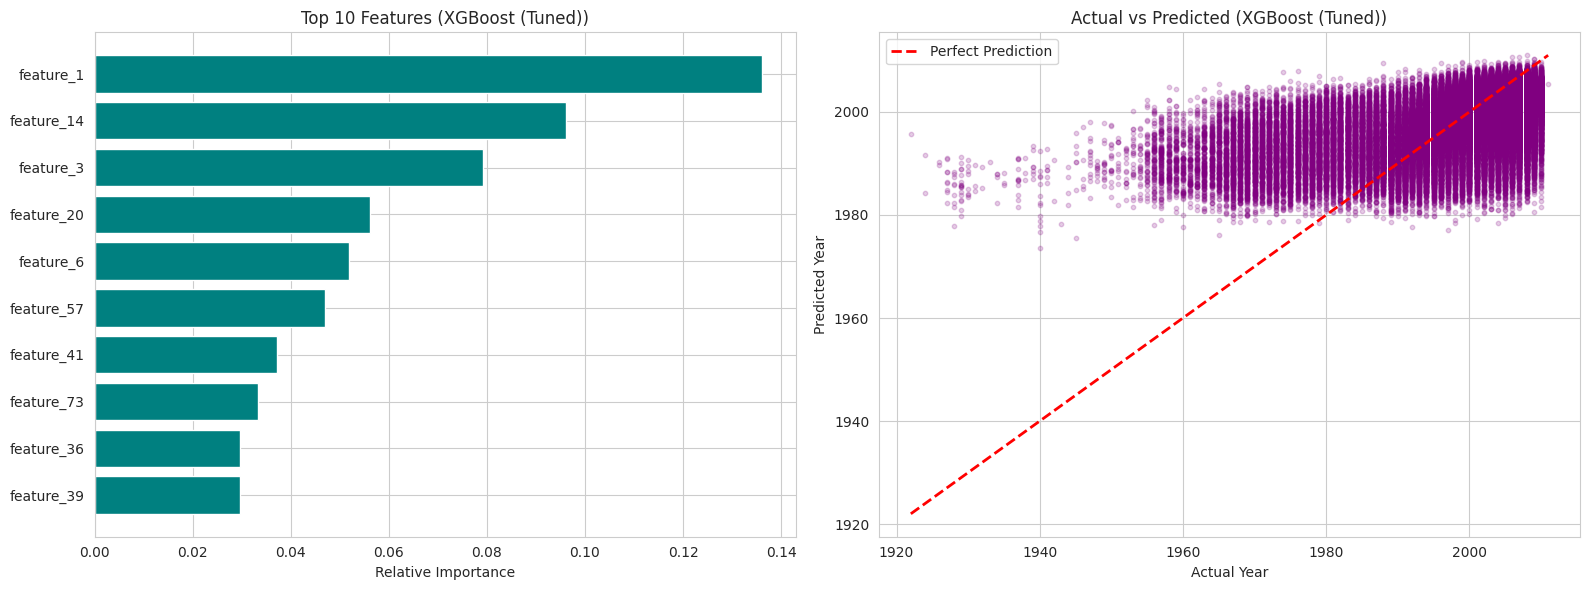

In [16]:
print(f"\n{'─'*50}")
print("PHASE 6: EVALUATION & RESULTS")
print(f"{'─'*50}")

def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

res_rf = print_metrics(y_test, y_pred_rf, "Random Forest")
res_xgb = print_metrics(y_test, y_pred_xgb, "XGBoost (Tuned)")

results_df = pd.DataFrame([res_rf, res_xgb]).sort_values('RMSE')

print("\n──────────────────────────────────────────────────")
print("EXECUTIVE SUMMARY: MODEL PERFORMANCE")
print("──────────────────────────────────────────────────")
print(results_df.to_string(index=False))

# Determine Best Model
best_model_name = results_df.iloc[0]['Model']
best_preds = y_pred_xgb if best_model_name == "XGBoost (Tuned)" else y_pred_rf
best_model_obj = best_xgb if best_model_name == "XGBoost (Tuned)" else rf_model

print(f"\n★ BEST MODEL: {best_model_name}")
print(f"  • RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"  • R²  : {results_df.iloc[0]['R2']:.4f}")

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Feature Importance
importances = best_model_obj.feature_importances_
indices = np.argsort(importances)[::-1][:10]
axes[0].barh(range(len(indices)), importances[indices], align='center', color='teal')
axes[0].set_yticks(range(len(indices)))
axes[0].set_yticklabels([selected_features[i] for i in indices])
axes[0].invert_yaxis()
axes[0].set_xlabel('Relative Importance')
axes[0].set_title(f'Top 10 Features ({best_model_name})', fontsize=12)

# 2. Actual vs Predicted
axes[1].scatter(y_test, best_preds, alpha=0.2, color='purple', s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Year')
axes[1].set_ylabel('Predicted Year')
axes[1].set_title(f'Actual vs Predicted ({best_model_name})', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Prediction Demo

In [18]:
print(f"\n{'─'*50}")
print("PHASE 7: SAMPLE PREDICTIONS")
print(f"{'─'*50}")

# Show 10 random samples from test set
sample_indices = np.random.choice(len(y_test), 10, replace=False)
sample_actual = y_test.iloc[sample_indices].values
sample_pred = best_preds[sample_indices]

print(f"{'Actual':<10} {'Predicted':<10} {'Diff (Years)':<10}")
print("—" * 35)
for act, pred in zip(sample_actual, sample_pred):
    print(f"{int(act):<10} {pred:<10.1f} {act-pred:>5.1f}")


──────────────────────────────────────────────────
PHASE 7: SAMPLE PREDICTIONS
──────────────────────────────────────────────────
Actual     Predicted  Diff (Years)
───────────────────────────────────
2005       2006.0      -1.0
1967       1993.4     -26.4
2003       1988.1      14.9
2005       2006.6      -1.6
1954       1988.5     -34.5
1998       2001.9      -3.9
1969       1988.1     -19.1
2007       2005.6       1.4
2004       2003.8       0.2
1982       2002.6     -20.6


## Summary – End-to-End Regression Pipeline

This end-to-end regression pipeline includes:

1. **Data Loading**  
   - Dataset `midterm-regresi-dataset.csv` diunduh dari Google Drive menggunakan `gdown`.  
   - Dataset tidak memiliki header; kolom pertama berisi **target** (tahun rilis lagu), kolom lain berisi fitur audio (feature_1, feature_2, ...).  

2. **Data Preparation**  
   - Memisahkan **target** (`y`) dan **fitur** (`X`).  
   - Membagi data menjadi **train** dan **validation** menggunakan `train_test_split` (80% / 20%).  
   - Menerapkan **StandardScaler** pada fitur numerik untuk menormalkan skala.  

3. **Exploratory Data Analysis (EDA)**  
   - Melihat distribusi tahun rilis dan beberapa fitur utama.  
   - Mengecek korelasi antara fitur dan target untuk mengetahui fitur yang paling berpengaruh.  
   - Mengamati outlier dan sebaran data menggunakan histogram / boxplot / heatmap (opsional).  

4. **Machine Learning Models**  
   - **Baseline: Mean Predictor** (misalnya memprediksi rata-rata tahun rilis sebagai baseline sederhana).  
   - **Linear Regression**: model regresi linear sebagai baseline klasik.  
   - **Tree-Based Models** (misalnya Random Forest / Gradient Boosting, jika digunakan):  
     - Menangkap hubungan non-linear antara fitur dengan tahun rilis.  
   - Evaluasi model menggunakan metrik:  
     - **MSE** (Mean Squared Error)  
     - **RMSE** (Root Mean Squared Error)  
     - **MAE** (Mean Absolute Error)  
     - **R²** (Coefficient of Determination)  

5. **Deep Learning Regression (ANN)**  
   - Menggunakan data yang telah di-scale (`StandardScaler`) sebagai input jaringan saraf.  
   - Arsitektur jaringan:  
     - Dense(128, ReLU) → Dropout(0.3) → Dense(64, ReLU) → Dropout(0.3) → Dense(1, Linear).  
   - Loss function: **MSE**, Optimizer: **Adam**, Metrics: **MAE, MSE**.  
   - Menggunakan **EarlyStopping** berbasis `val_loss` untuk mencegah overfitting.  
   - Membandingkan performa ANN dengan model ML (Linear Regression / Random Forest) menggunakan RMSE dan R².  

6. **Model Comparison & Selection**  
   - Menyajikan tabel / ringkasan metrik untuk semua model (ML dan DL).  
   - Model dengan **RMSE terendah** dan **R² tertinggi** dipilih sebagai model terbaik untuk memprediksi tahun rilis lagu.  
   - Dicatat bahwa:  
     - Jika model ML sederhana (misalnya Random Forest) sudah sangat bagus, ANN menjadi pembanding yang menunjukkan bahwa deep learning tidak selalu mengungguli model klasik pada dataset berukuran terbatas.  
     - Sebaliknya, jika ANN memberi perbaikan signifikan, maka deep learning bisa direkomendasikan sebagai model utama.  

**Key Takeaway:**  
Dengan pipeline ini, proses prediksi tahun rilis lagu telah dibangun secara **end-to-end** mulai dari **pengambilan data**, **preprocessing**, **training model machine learning dan deep learning**, hingga **evaluasi dan perbandingan performa**. Pendekatan ini dapat dengan mudah digeneralisasi ke masalah regresi lain di domain berbeda.
